#SKIP GRAM Model

In skip gram architecture of word2vec, the input is the center word and the predictions are the context words. 

Steps for Training the Word Embeddings for CBOW

1. Build the corpus vocabulary
2. Build a skip-gram [(target, context), relevancy] generator
3. Build the Skip Gram model architecture
4. Train the Model
5. Get Word Embeddings




# Build COrpus Vocabulary

In [ ]:
sent1 = "He is playing in the field.".lower()
sent2 = "He is running around with his friends.".lower()
sent3 = "They are playing football.".lower()
sent4 = "It started raining while they were playing.".lower()
sent5 = "They stopped playing football and are now playing ludo.".lower()
all_text = [sent1, sent2, sent3, sent4, sent5]


In [ ]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(all_text)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in all_text]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 24
Vocabulary Sample: [('playing', 1), ('they', 2), ('he', 3), ('is', 4), ('are', 5), ('football', 6), ('in', 7), ('the', 8), ('field', 9), ('running', 10)]


#Build a skip-gram [(target, context), relevancy] generator


This function transforms a sequence of word indexes (list of integers) into tuples of words of the form:
- (word, word in the same window), with label 1 (positive samples).
- (word, random word from the vocabulary), with label 0 (negative samples).

In [ ]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(the (8), in (7)) -> 1
(in (7), were (19)) -> 0
(is (4), he (3)) -> 0
(in (7), and (21)) -> 0
(he (3), field (9)) -> 1
(the (8), it (15)) -> 0
(playing (1), were (19)) -> 0
(is (4), the (8)) -> 0
(the (8), is (4)) -> 1
(he (3), in (7)) -> 1


# Build the skip-gram model architecture

our inputs will be our target word and context or random word pair. Each of which are passed to an embedding layer (initialized with random weights) of it’s own. Once we obtain the word embeddings for the target and the context word, we pass it to a merge layer where we compute the dot product of these two vectors. Then we pass on this dot product value to a dense sigmoid layer which predicts either a 1 or a 0 depending on if the pair of words are contextually relevant or just random words


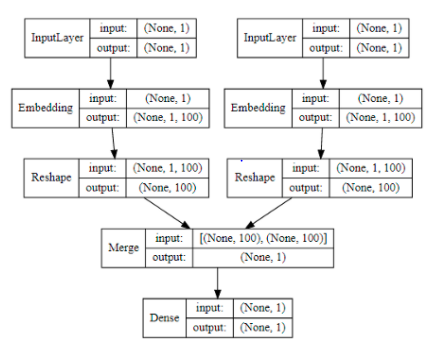


In [ ]:
from keras.layers import Input
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape
from keras.layers import dot

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, embed_size, input_length=1, name='embedding')

word_embedding = embedding(input_target)
word_embedding = Reshape((embed_size, 1))(word_embedding)
context_embedding = embedding(input_context)
context_embedding = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding, context_embedding], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

model = Model([input_target, input_context],output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       2400        input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 100, 1)       0           embedding[0][0]            

#Train the Model



In [ ]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 1.250576063990593
Epoch: 2 Loss: 1.2475573867559433
Epoch: 3 Loss: 1.245061531662941
Epoch: 4 Loss: 1.2424326837062836
Epoch: 5 Loss: 1.2395437359809875


# Get Word Embeddings



In [ ]:
model.layers

In [ ]:
import pandas as pd
word_embed_layer = model.layers[2]
# word_model = merge_layer.layers[0]
# word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(23, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
playing,-0.042207,0.045161,-0.008626,-0.036300,0.000811,-0.069369,0.028993,0.039979,-0.027112,-0.012414,-0.005290,0.044571,-0.050694,0.005843,0.017170,0.018021,-0.005349,-0.014316,0.037517,0.013592,0.029216,0.013459,-0.054972,-0.054702,0.003651,0.046374,0.046460,0.063735,0.030172,-0.022017,-0.049690,0.029900,0.033399,0.006434,0.017476,0.025643,-0.066217,0.024153,-0.033839,-0.053205,...,0.014365,0.059693,0.039570,0.029092,0.039705,0.011242,-0.027890,0.004707,0.022954,-0.051137,0.025982,0.054603,-0.048651,-0.004730,-0.039638,-0.016351,0.013448,-0.040104,0.052403,-0.059917,-0.006764,-0.024437,-0.039985,-0.045380,0.010073,0.028913,-0.019824,0.036359,0.012102,0.014707,0.042764,0.015507,-0.044524,0.040529,0.021249,-0.021708,0.017013,0.054085,-0.016829,0.004964
they,-0.068721,0.019457,-0.035052,-0.051584,0.031935,-0.059574,-0.034322,0.000048,-0.021183,0.022630,0.019718,0.023196,0.009490,-0.047208,0.003022,0.016188,-0.061580,-0.012464,0.057656,0.042445,0.062592,0.043572,-0.050269,-0.017040,0.022846,0.045356,0.011920,0.063269,0.004244,0.037772,0.012203,0.029656,0.053592,-0.003676,-0.006171,-0.043457,0.025006,0.050248,-0.065670,-0.017144,...,0.026037,-0.005060,0.034659,-0.044948,0.007078,0.034216,-0.044596,-0.049292,-0.001772,-0.060595,0.022509,0.023014,-0.074884,-0.013342,-0.035051,-0.037969,0.060745,0.013986,0.021715,-0.033201,-0.006933,-0.028006,-0.037669,-0.042870,0.014567,-0.027458,0.038968,0.055521,0.047010,0.036896,0.021778,-0.024664,0.011129,0.050363,-0.047038,-0.005729,-0.015923,0.057424,-0.035400,0.001314
he,0.050326,-0.033159,0.052118,0.013272,0.010548,0.017773,-0.006028,-0.033380,-0.029416,0.037038,0.051537,-0.033144,0.047994,0.015479,0.002743,0.006083,0.044046,0.030204,-0.022170,0.024345,-0.049234,0.022148,0.020766,0.027490,0.015957,0.041159,-0.043953,-0.045040,-0.028971,-0.003664,0.041496,0.051220,-0.038954,-0.024426,0.015776,0.032169,0.034118,-0.052081,0.034970,0.030963,...,-0.011709,-0.057347,-0.044149,0.045034,0.030363,-0.005414,0.035963,-0.015652,0.040099,0.006431,-0.021051,-0.068666,0.032642,-0.057086,-0.014155,0.045434,-0.036356,-0.013208,0.027111,-0.028247,-0.016537,-0.018280,-0.008792,0.020382,-0.027857,0.035989,-0.021096,-0.059248,-0.050663,-0.070349,-0.030097,-0.017602,-0.034346,-0.053862,-0.024782,-0.053602,0.035843,-0.014352,0.021421,-0.006404
is,0.017731,-0.041098,0.009619,-0.010512,0.029869,-0.006747,-0.019524,-0.039836,-0.009235,0.036422,-0.014387,-0.050449,0.035986,0.000758,-0.025108,-0.035945,0.068113,0.030218,0.041416,0.030590,-0.004781,-0.000241,0.022366,-0.010077,-0.006743,0.000433,-0.013150,-0.019499,-0.060619,-0.032023,0.052861,0.018295,-0.023692,-0.009979,0.038575,0.032398,0.027374,-0.044561,-0.005871,0.020345,...,-0.063101,-0.036226,-0.031572,0.045290,-0.010147,-0.000465,0.015377,0.024482,-0.011108,-0.018687,0.014699,0.028698,0.044311,-0.025523,0.033301,-0.015214,0.013661,-0.001415,-0.037637,0.040300,0.005256,0.030458,0.056740,-0.004952,-0.025363,-0.005622,-0.033922,-0.023637,-0.053459,-0.037872,-0.047896,-0.033108,0.048565,0.002634,0.014723,-0.049247,0.040245,-0.031913,0.028734,0.024746
are,0.013809,0.016029,-0.018411,-0.065250,0.016574,0.007267,-0.006494,0.044193,-0.037026,0.010984,0.026522,0.016100,-0.063120,-0.051741,0.031619,-0.011320,-0.066082,-0.015933,0.046863,0.062386,0.045021,0.058434,-0.049682,-0.064880,-0.017397,-0.006255,-0.030065,-0.035312,-0.010618,0.050258,-0.059322,0.024234,-0.005165,0.010462,0.050988,-0.008381,-0.039471,0.030827,-0.038630,-0.055046,...,0.022819,0.042728,-0.001244,-0.038476,0.041661,-0.021784,-0.018505,-0.047753,-0.032885,-0.033458,-0.001124,0.016474,0.029731,0.033849,-0.038498,0.003343,0.040077,-0.043461,0.026002,0.024531,-0.052527,-0.029146,-0.058701,-0.007107,0.048137,-0.007731,0.060189,0.027014,0.045887,0.047321,0.027191,0.028971,-